In [1]:
import numpy
import scipy

from metricdiversity.acquisitions.cas import ConstraintActiveSearchService
from metricdiversity.acquisitions.expected_metric_coverage import ExpectedMetricCoverageService

from metricdiversity.utilities.sigopt_colors import *

import matplotlib.pyplot as plt
%matplotlib inline

## 2D test function

In [55]:
# define objective 
def f_1(x, scale_x=1):
  return numpy.exp(-0.5* ((x[0]-0.2)**2 + scale_x * (x[1]-0.5)**2))

def f_2(x, scale_y=1):
  return numpy.exp(-0.5* ((x[0]-0.8)**2 + scale_y *(x[1]-0.5)**2))

def two_humps_unscaled(x):
  return [f_1(x), f_2(x)]

def two_humps_scaled(x):
  return [f_1(x, 4), f_2(x, 4)]

In [85]:
def ellipse_points(center, radius_x, radius_y, angle_rad=0):
  assert len(center) == 2
  num_points = 1000
  theta = numpy.linspace(0, 2 * numpy.pi, num_points)
  xs = radius_x * numpy.cos(theta) 
  ys = radius_y * numpy.sin(theta)
  if angle_rad != 0:
    rot_mat = numpy.array([
      [numpy.cos(angle_rad), -numpy.sin(angle_rad)],
      [numpy.sin(angle_rad), numpy.cos(angle_rad)],
    ])
    rotated = numpy.dot(rot_mat, numpy.array([xs, ys]))
    xs = rotated[0]
    ys = rotated[1]
    
  return xs + center[0], ys + center[1]

threshold = 0.85
radius = numpy.sqrt(-2 * numpy.log(threshold))
print(radius)
x_c1, y_c1 = ellipse_points([0.2, 0.5], radius, radius)
x_c2, y_c2 = ellipse_points([0.8, 0.5], radius, radius)
x_ell1, y_ell1 = ellipse_points([0.2, 0.5], radius, radius / 2)
x_ell2, y_ell2 = ellipse_points([0.8, 0.5], radius, radius / 2)


x_0 = numpy.linspace(0.2+radius, 0.8-radius, 100)
x_1 = numpy.ones(100) * 0.5
xxx = numpy.vstack((x_0, x_1)).T
y_0 = numpy.array([f_1(xx) for xx in xxx])
y_1 = numpy.array([f_2(xx) for xx in xxx])
yyy = numpy.vstack((y_0, y_1)).T

x_c1_p = x_c1[x_c1>=0.5]
y_c1_p = y_c1[x_c1>=0.5]
x_c2_p = x_c2[x_c2<=0.5]
y_c2_p = y_c2[x_c2<=0.5]
sorted_idx = numpy.argsort(y_c1_p)

0.5701209161182826


In [76]:
parameters = [
  {'name': 'x0', 'type': 'double', 'bounds': {'min': 0, 'max': 1}},
  {'name': 'x1', 'type': 'double', 'bounds': {'min': 0, 'max': 1}}
]
param_names = ['x0', 'x1']
threshold = 0.85
constraints = [("gt", threshold)] * 2

def objective_function(suggestion):
  print("suggestions:", suggestion)
  pt = numpy.array([suggestion[p] for p in param_names])
  values = two_humps_unscaled(pt)
  print("obj:", values)
  return values

In [77]:
cas = ConstraintActiveSearchService(
  parameters=parameters,
  constraints=constraints,
  punchout_radius=0.1,
  num_init_points=6,
)

In [78]:
for i in range(20):
  suggestion = cas.create_suggestion()
  values = objective_function(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  cas.create_observation(observation)

suggestions: {'id': 6, 'x0': 0.6836956143379211, 'x1': 0.2693488895893097}
obj: [0.8662508986883343, 0.9671870949808044]
suggestions: {'id': 5, 'x0': 0.37274035811424255, 'x1': 0.7273457646369934}
obj: [0.9600569589796192, 0.8894798288013946]
suggestions: {'id': 4, 'x0': 0.43686825037002563, 'x1': 0.3841566741466522}
obj: [0.9658341739441128, 0.9299335268757901]
suggestions: {'id': 3, 'x0': 0.6239603161811829, 'x1': 0.61180579662323}
obj: [0.9083536962379819, 0.9784894703469342]
suggestions: {'id': 2, 'x0': 0.9017660617828369, 'x1': 0.03809421509504318}
obj: [0.7026360157430639, 0.8941724344319445]
suggestions: {'id': 1, 'x0': 0.08873596042394638, 'x1': 0.9649631381034851}
obj: [0.8920035173888041, 0.6969485921008802]
 >>> x_next tensor([[0.4964, 0.1966]], dtype=torch.float64) eci tensor(0.9424, dtype=torch.float64)
suggestions: {'id': 7, 'x0': 0.4963667434683191, 'x1': 0.19655932744037324}
obj: [0.9139725468952452, 0.9119822989723255]
 >>> x_next tensor([[0.5547, 0.7974]], dtype=torch

In [79]:
cas_points = numpy.array(cas.get_points())
cas_values = numpy.array(cas.get_values())
cas_feasible_inds = numpy.array(cas.get_feasible_indices())

In [80]:
hypers = numpy.array([[0.01, 0.3, 0.3], [0.01, 0.3, 0.3]])
emcs = ExpectedMetricCoverageService(
  parameters=parameters,
  constraints=constraints,
  punchout_radius=0.03,
  num_init_points=6,
  hyperparameters=hypers,
  verbose=False,
)

In [81]:
for i in range(20):
  suggestion = emcs.create_suggestion()
  values = objective_function(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  emcs.create_observation(observation)

suggestions: {'id': 6, 'x0': 0.8597668912261724, 'x1': 0.5074677921365947}
obj: [0.8043875815633916, 0.9981877195638328]
suggestions: {'id': 5, 'x0': 0.4670851833652705, 'x1': 0.157249960815534}
obj: [0.9099132239934297, 0.8921197270598848]
suggestions: {'id': 4, 'x0': 0.5625127754174173, 'x1': 0.7880974388681352}
obj: [0.8983389578119345, 0.9326734325943831]
suggestions: {'id': 3, 'x0': 0.232599112438038, 'x1': 0.37658886471763253}
obj: [0.9918865876272862, 0.8448577256956759]
suggestions: {'id': 2, 'x0': 0.9755792922805995, 'x1': 0.031449477886781096}
obj: [0.6632976700017293, 0.8823346794203133]
suggestions: {'id': 1, 'x0': 0.32111903093755245, 'x1': 0.6314384273719043}
obj: [0.9841539509770278, 0.8839970783710371]
suggestions: {'id': 7, 'x0': 0.42851173277013005, 'x1': 0.7150060115847736}
obj: [0.9519691991810364, 0.9119997538095403]
suggestions: {'id': 8, 'x0': 0.69486383786425, 'x1': 0.623099425463006}
obj: [0.8780762506390674, 0.9869819370582269]
suggestions: {'id': 9, 'x0': 0.5

In [82]:
emcs_points = numpy.array(emcs.get_points())
emcs_values = numpy.array(emcs.get_values())
emcs_feasible_inds = numpy.array(emcs.get_feasible_indices())

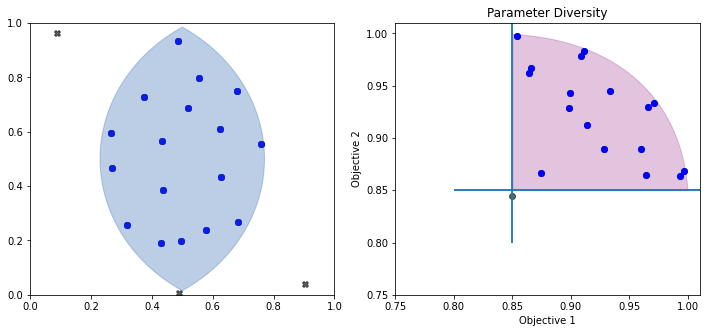

In [95]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(cas_points[:, 0], cas_points[:, 1], marker='X', color='black', alpha=0.6)
axes[0].scatter(cas_points[cas_feasible_inds, 0], cas_points[cas_feasible_inds, 1], marker='o', color='blue')
axes[0].fill(
  numpy.append(x_c1_p[sorted_idx], x_c2_p),
  numpy.append(y_c1_p[sorted_idx], y_c2_p),
  color=sigopt_blue, 
  alpha=0.3
)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].fill_between(yyy[:, 0], threshold, yyy[:, 1], alpha=0.3, color=sigopt_magenta)
axes[1].scatter(cas_values[:, 0], cas_values[:, 1], color="black", alpha=0.6)
axes[1].scatter(cas_values[cas_feasible_inds, 0], cas_values[cas_feasible_inds, 1], marker='o', color='blue')
axes[1].vlines([threshold] * 2, 0.8, 1.01)
axes[1].hlines([threshold] * 2, 0.8, 1.01)
axes[1].set_xlim([0.75, 1.01])
axes[1].set_ylim([0.75, 1.01])
plt.title("Parameter Diversity")
plt.show()

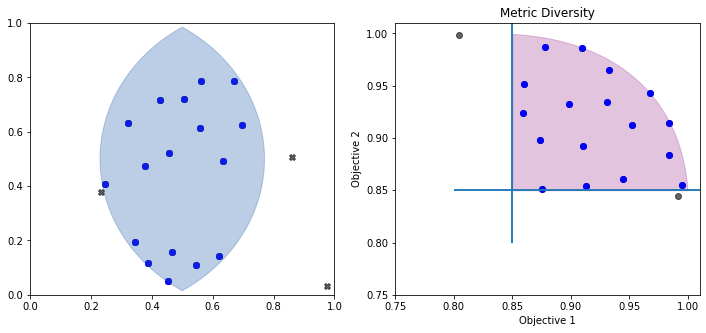

In [94]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(emcs_points[:, 0], emcs_points[:, 1], marker='X', color='black', alpha=0.6)
axes[0].scatter(emcs_points[emcs_feasible_inds, 0], emcs_points[emcs_feasible_inds, 1], marker='o', color='blue')
axes[0].fill(
  numpy.append(x_c1_p[sorted_idx], x_c2_p),
  numpy.append(y_c1_p[sorted_idx], y_c2_p),
  color=sigopt_blue, 
  alpha=0.3
)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

axes[1].set_xlabel('Objective 1')
axes[1].set_ylabel('Objective 2')
axes[1].fill_between(yyy[:, 0], threshold, yyy[:, 1], alpha=0.3, color=sigopt_magenta)
axes[1].scatter(emcs_values[:, 0], emcs_values[:, 1], color="black", alpha=0.6)
axes[1].scatter(emcs_values[emcs_feasible_inds, 0], emcs_values[emcs_feasible_inds, 1], marker='o', color='blue')
axes[1].vlines([threshold] * 2, 0.8, 1.01)
axes[1].hlines([threshold] * 2, 0.8, 1.01)
axes[1].set_xlim([0.75, 1.01])
axes[1].set_ylim([0.75, 1.01])
plt.title("Metric Diversity")
plt.show()

### EMI Problem from Mike

In [80]:
def evaluate_emi_problem(suggestion):
  s = suggestion['silvert']
  b = suggestion['bott']
  p = suggestion['pitch']
  cbotr = suggestion['cbotr']
  ctopr = suggestion['ctopr']

  emi_se = 7.5 * numpy.log(s) + 22
  transmission = .91 / (.65 - .22) * (
      (.4 + .5 * numpy.exp(-.001 * (s - 5) ** 2)) *
      (.6 + .25 * numpy.exp(-.0005 * (b - 40) ** 2)) *
      (.6 + .25 * numpy.exp(-.000005 * (p - 100) ** 2)) - .22
  )
  values = [emi_se, transmission, 0.5 * p - cbotr, cbotr - ctopr]
  print("suggestions:", suggestion)
  print("obj:", values)
  return values
  
parameters=[
  dict(name="silvert", bounds=dict(min=1, max=50), type="double"),
  dict(name="bott", bounds=dict(min=40, max=100), type="double"),
  dict(name="pitch", bounds=dict(min=10, max=400), type="double"),
  dict(name="cbotr", bounds=dict(min=20, max=200), type="double"),
  dict(name="ctopr", bounds=dict(min=10, max=200), type="double"),
]


thresholds = [40, 0.6, 0, 0]
constraints = [("gt", t) for t in thresholds]
punchout_radius_param = 0.1 * numpy.sqrt(len(parameters))
punchout_radius_metric = 20

metric_names = [
  "EMI_SE",
  "Transmission",
  "0.5 pitch - cbotr",
  "cbotr - ctopr",
]

param_names = [
  "silvert",
  "bott",
  "pitch",
  "cbotr",
  "ctopr",
]

In [70]:
cas = ConstraintActiveSearchService(
  parameters=parameters,
  constraints=constraints,
  punchout_radius=punchout_radius_param,
  num_init_points=10 * len(parameters),
  verbose=False,
)

In [71]:
for i in range(100):
  suggestion = cas.create_suggestion()
  values = evaluate_emi_problem(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  cas.create_observation(observation)

suggestions: {'id': 50, 'bott': 72.79249787330627, 'cbotr': 21.34168168529868, 'ctopr': 156.5356332063675, 'pitch': 113.02520394325256, 'silvert': 13.795961678028107}
obj: [41.682819379833276, 0.6919554567754822, 35.1709202863276, -135.1939515210688]
suggestions: {'id': 49, 'bott': 59.27118003368378, 'cbotr': 192.67674326896667, 'ctopr': 43.07430520653725, 'pitch': 233.85932624340057, 'silvert': 39.576472878456116}
obj: [49.58676116853073, 0.3151197848621578, -75.74708014726639, 149.60243806242943]
suggestions: {'id': 48, 'bott': 62.24756121635437, 'cbotr': 28.36125150322914, 'ctopr': 143.40533792972565, 'pitch': 33.673361502587795, 'silvert': 10.339304730296135}
obj: [39.519644695268354, 0.7935870132246624, -11.524570751935244, -115.0440864264965]
suggestions: {'id': 47, 'bott': 71.69844269752502, 'cbotr': 199.71967697143555, 'ctopr': 76.98476612567902, 'pitch': 349.5116317272186, 'silvert': 36.909530997276306}
obj: [49.06352357727852, 0.25734223616609453, -24.963861107826233, 122.734

suggestions: {'id': 51, 'bott': 47.38413074524363, 'cbotr': 64.43932062674364, 'ctopr': 10.0, 'pitch': 235.83326487706583, 'silvert': 19.58624104378959}
obj: [44.311204991245575, 0.7226681225964443, 53.47731181178928, 54.43932062674364]
suggestions: {'id': 52, 'bott': 40.0, 'cbotr': 135.4899449191625, 'ctopr': 85.49379375470883, 'pitch': 379.0693932836273, 'silvert': 17.68406679108459}
obj: [43.544980396589764, 0.6771506324220853, 54.04475172265114, 49.996151164453664]
suggestions: {'id': 53, 'bott': 47.41939442482791, 'cbotr': 64.3081773242153, 'ctopr': 10.0, 'pitch': 372.5763432567573, 'silvert': 17.247171743896633}
obj: [43.3573612986956, 0.6789618374416028, 121.97999430416336, 54.30817732421529]
suggestions: {'id': 54, 'bott': 59.760203634477584, 'cbotr': 119.24373209305092, 'ctopr': 74.88653958095058, 'pitch': 323.0838988051144, 'silvert': 16.319461567552487}
obj: [42.94268767605567, 0.6727391089109641, 42.298217309506285, 44.35719251210034]
suggestions: {'id': 55, 'bott': 64.4946

suggestions: {'id': 85, 'bott': 41.108732779978475, 'cbotr': 29.98528920220307, 'ctopr': 25.709885964546118, 'pitch': 134.2473508211068, 'silvert': 19.32409740005726}
obj: [44.21014665285051, 0.766368522595374, 37.13838620835033, 4.275403237656953]
suggestions: {'id': 86, 'bott': 52.67612375858633, 'cbotr': 95.90627664433836, 'ctopr': 115.25137287172173, 'pitch': 400.0, 'silvert': 16.6797163261085}
obj: [43.10645042468467, 0.6508260781813491, 104.09372335566164, -19.345096227383365]
suggestions: {'id': 87, 'bott': 41.84813960178331, 'cbotr': 147.93082608906454, 'ctopr': 62.79116427734947, 'pitch': 367.7900694458443, 'silvert': 19.186484407966457}
obj: [44.15654570551458, 0.6609928020740476, 35.96420863385762, 85.13966181171506]
suggestions: {'id': 88, 'bott': 76.83398087147057, 'cbotr': 24.292473925500193, 'ctopr': 22.21151225155632, 'pitch': 274.3963323771165, 'silvert': 8.010213593714886}
obj: [37.60538069955061, 0.6566942007580938, 112.90569226305806, 2.0809616739438717]
suggestions

In [72]:
cas_points = numpy.array(cas.get_points())
cas_values = numpy.array(cas.get_values())
cas_feasible_inds = numpy.array(cas.get_feasible_indices())

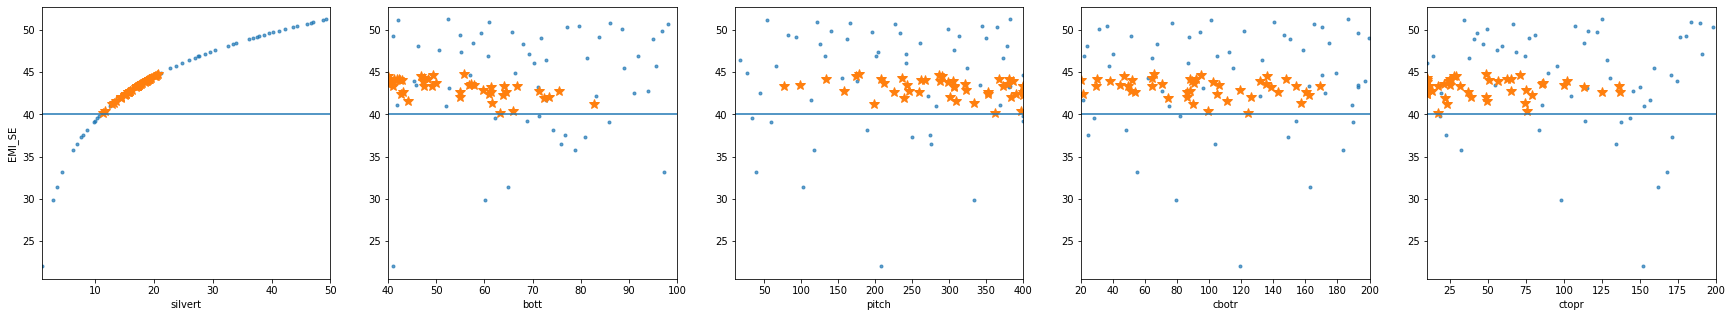

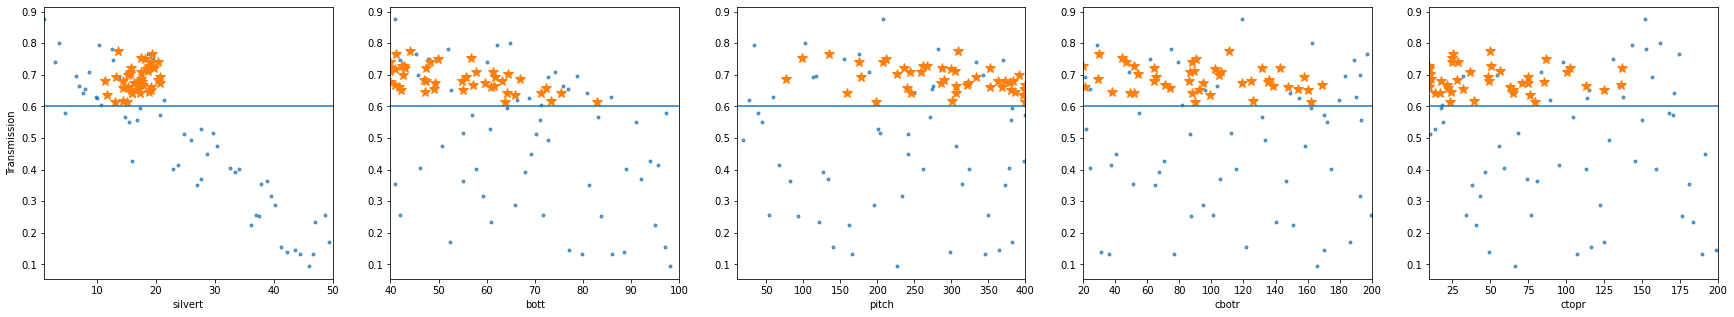

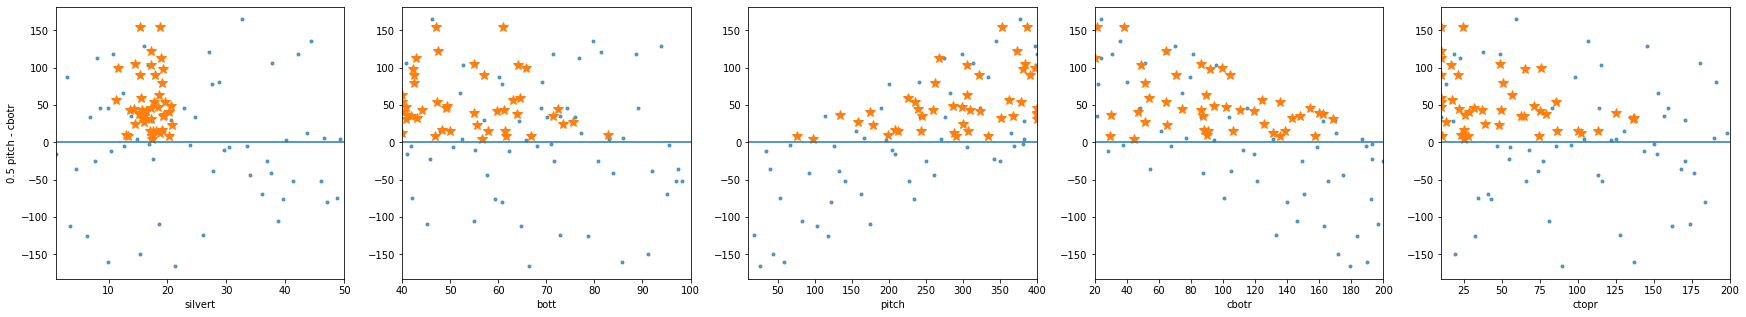

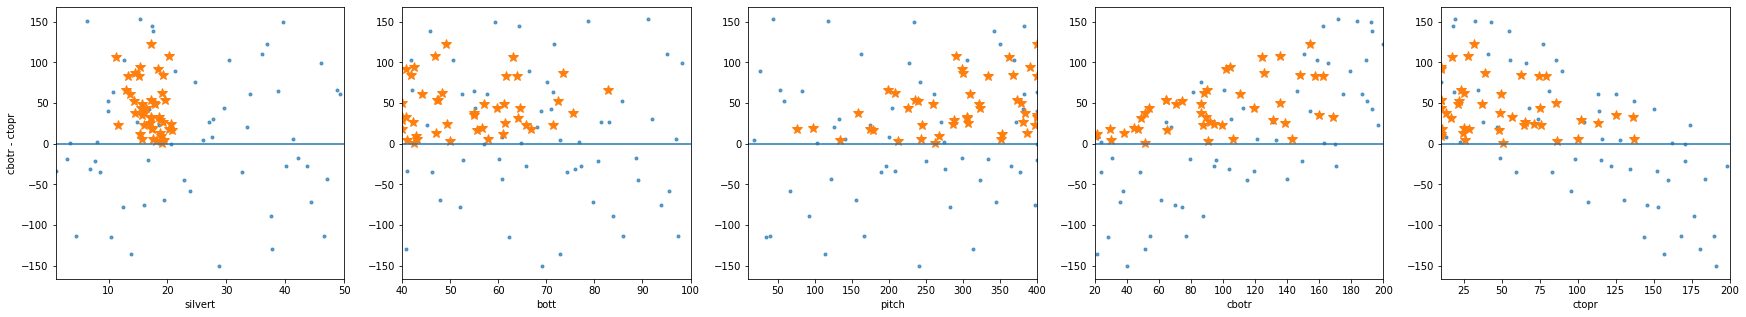

In [84]:
for i in range(len(metric_names)):
  fig, axes = plt.subplots(1, len(parameters), figsize=(6 * len(parameters), 5))
  for j, ax in enumerate(axes):
    cas_param_idx = cas.domain.parameters_name.index(parameters[j]["name"])
    ax.plot(cas_points[:, cas_param_idx], cas_values[:, i], ".", alpha=0.7)
    ax.plot(cas_points[cas_feasible_inds, cas_param_idx], cas_values[cas_feasible_inds, i], "*", markersize=10)
    ax.hlines(thresholds[i], parameters[j]["bounds"]["min"], parameters[j]["bounds"]["max"])
    ax.set_xlim([parameters[j]["bounds"]["min"], parameters[j]["bounds"]["max"]])
    ax.set_xlabel(param_names[j])
  axes[0].set_ylabel(metric_names[i])

In [54]:
hypers = numpy.array([
  [20, 5, 100, 400, 200, 200],
  [0.4, 5, 10, 100, 200, 200],
  [20, 50, 100, 100, 50, 200],
  [20, 50, 100, 400, 50,  50],
])
emcs = ExpectedMetricCoverageService(
  parameters=parameters,
  constraints=constraints,
  punchout_radius=punchout_radius_metric,
  num_init_points=5 * len(parameters),
  hyperparameters=hypers,
  verbose=False,
)

In [55]:
for i in range(100):
  suggestion = emcs.create_suggestion()
  values = evaluate_emi_problem(suggestion)
  observation = {'suggestion': suggestion['id'], 'values': values}
  emcs.create_observation(observation)

 >>> x_next [ 15.40848938  47.98157974 139.14524767  67.59693341  63.248996  ] emc 0.876953125
 >>> x_next [ 14.8539347   48.81809849 156.93402575  73.42327849  15.18617781] emc 0.98828125
 >>> x_next [ 12.86681466  49.57712669 166.08125317  56.41584945  10.        ] emc 0.99609375
 >>> x_next [ 13.6030156   47.28709184 147.08813478  20.          10.        ] emc 1.0
 >>> x_next [ 15.04611431  50.35111537 135.82254079  40.09848146  24.32445316] emc 0.99609375
 >>> x_next [ 14.14733167  52.31949548 198.19268209  20.          10.        ] emc 0.953125
 >>> x_next [ 13.19988905  47.82439695 198.56913525  44.94954004  10.        ] emc 1.0
 >>> x_next [ 16.77271697  48.2869647  184.84486157  83.55880672  58.11666405] emc 1.0
 >>> x_next [ 14.63864967  52.27532043 188.51167005  91.45835444  10.        ] emc 1.0
 >>> x_next [ 13.47005076  47.90503002 234.48976484  72.19475801  10.        ] emc 1.0
 >>> x_next [ 12.43461264  49.19156235 251.64750754 103.78692311  11.9525873 ] emc 1.0
 >>> x_ne

In [63]:
emcs_points = numpy.array(emcs.get_points())
emcs_values = numpy.array(emcs.get_values())
emcs_feasible_inds = numpy.array(emcs.get_feasible_indices())

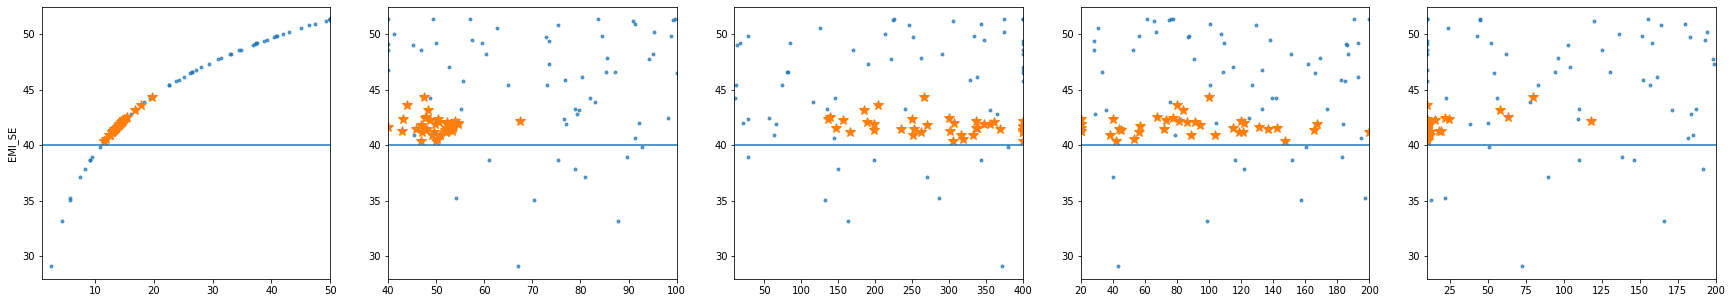

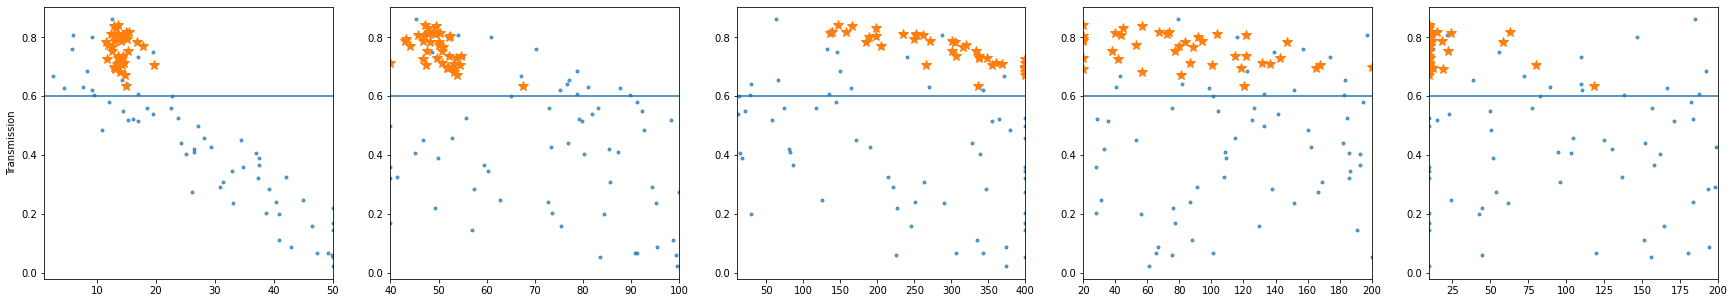

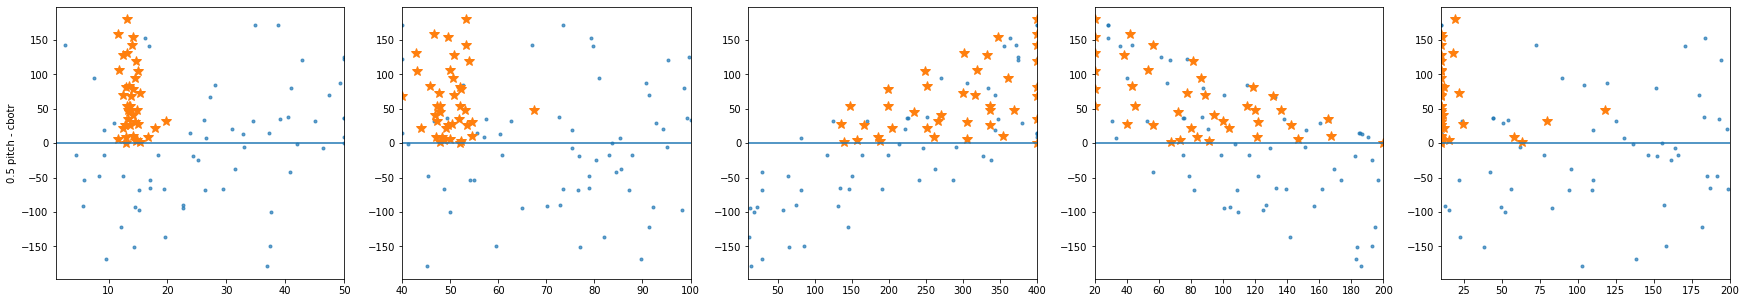

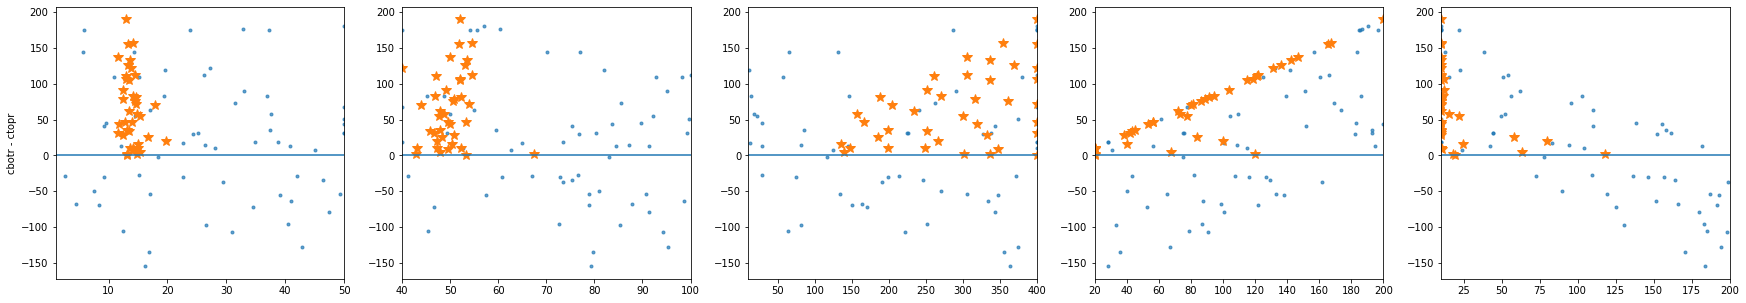

In [64]:
for i in range(len(metric_names)):
  fig, axes = plt.subplots(1, len(parameters), figsize=(6 * len(parameters), 5))
  for j, ax in enumerate(axes):
    ax.plot(emcs_points[:, j], emcs_values[:, i], ".", alpha=0.7)
    ax.plot(emcs_points[emcs_feasible_inds, j], emcs_values[emcs_feasible_inds, i], "*", markersize=10)
    ax.hlines(thresholds[i], parameters[j]["bounds"]["min"], parameters[j]["bounds"]["max"])
    ax.set_xlim([parameters[j]["bounds"]["min"], parameters[j]["bounds"]["max"]])
  axes[0].set_ylabel(metric_names[i])